In [1]:
import json
from SongShu import SongShu
import re
import pandas as pd
import altair

altair.renderers.enable("notebook")
altair.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

# SongShu -- Geo Viz Linking Scatter Plot

In [2]:
songshu = SongShu("2018-08-21", "MF")
songshu.load_htmls()
songshu.extract_all()

INFO:root:Stop at loading data/SongShu_0851.html.
INFO:root:Total length of the data is 851.
ERROR:root:[Error] SongShu_rare_char.json does not exist

            try to run these lines: 
            	>> self.extract_rare_chars()
            	>> self.write_rare_chars()



## Extract Passages Contain 州郡

In [4]:
flat_bodies = []

for path,body in zip(songshu.paths, songshu.flat_bodies):
    if re.search(r"\／(['州郡']+)", path) != None:
        flat_bodies.append(body)
        
songshuGeo = SongShu(date='2018-8-21', creator='MF')
songshuGeo.filename = 'ShongShuGeo'
songshuGeo.flat_bodies = flat_bodies
songshuGeo.extract_paths()

In [5]:
songshuGeo[0]

## Get Rid of `page`, `a`, `span` tags

In [7]:
SongshuGeostrip = songshuGeo

for j in SongshuGeostrip.flat_bodies:
    for i in j.find_all("table", {"class":"page"}):
        i.extract()
    for i in j.find_all("a", {"href":"#"}):
        i.extract()
    for i in j.find_all("span", {"style":"display:none;width:;height:;color:red;font-size:13px"}):
        i.extract() 

## Get the Table of 州 郡

In [9]:
GeoS = []

for num,body in enumerate(SongshuGeostrip.flat_bodies):
    Geo = body.find_all("div",{"style":re.compile(r"text-indent:.em;padding-left:.em;")})
    for g in Geo:
        GeoS.append((num, g))
        
zhou = []

for number,(num,i) in enumerate(GeoS):
    for match in re.finditer(r'<div style="text-indent:2em;padding-left:0em;">([\w]*?州)刺史', str(i)):
        zhou.append((num, match.group(1)))
                
jun = []

for number,(num,i) in enumerate(GeoS):
    for match in re.finditer(r'<div style="text-indent:2em;padding-left:0em;">([\w]*?)(太守|相|尹)', str(i)):
        jun.append((num, zhou[num - 1][1], match.group(1)))

In [12]:
jun[:5]

[(1, '揚州', '丹陽'),
 (1, '揚州', '會稽'),
 (1, '揚州', '吳郡'),
 (1, '揚州', '吳興'),
 (1, '揚州', '淮南')]

## 列傳

In [13]:
# get all pages for 列傳
flat_bodies = []

for path,body in zip(songshu.paths, songshu.flat_bodies):
    if re.search(r"\／(列傳)", path) != None:
        flat_bodies.append(body)

In [18]:
songshuLie = SongShu(date='2018-8-14', creator='Z')
songshuLie.flat_bodies = flat_bodies
songshuLie.bookname = "SongShuLie"
songshuLie.extract_all()

ERROR:root:[Error] SongShuLie_rare_char.json does not exist

            try to run these lines: 
            	>> self.extract_rare_chars()
            	>> self.write_rare_chars()



## Linking Scatter Plot

In [19]:
def count_zhou(zhou):
    
    zhou_count_each_bio_list_Yu = []

    for i,(body,path) in enumerate(zip(songshuLie.flat_bodies, songshuLie.paths)):
        zhou_count_each_bio_list_Yu.append((i, path, str(body).count(zhou)))
        
    return zhou_count_each_bio_list_Yu
    
def make_dataframe(zhou_count_each_bio_list, name):
    data = pd.DataFrame(zhou_count_each_bio_list, columns=["index", "path", "count"])
    data["category"] = name
    return  data

    
every_zhou_count_each_bio_list = [
    (count_zhou(zhou), zhou) for zhou in set(j[1] for j in jun)
]
data = pd.concat([
    make_dataframe(zhou_count_each_bio_list[0], zhou_count_each_bio_list[1])
    for zhou_count_each_bio_list in every_zhou_count_each_bio_list
])

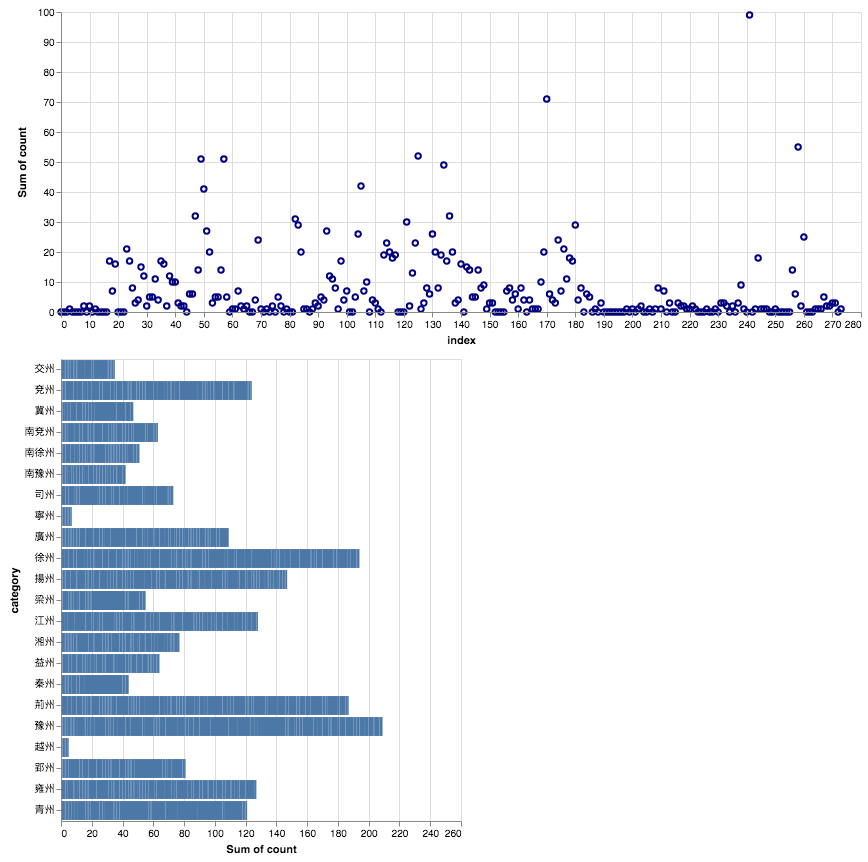

In [28]:
brush = altair.selection_interval(encodings=['x'])

points = altair.Chart(data).mark_point().encode(
    x="index",
    y="sum(count)",
    color=altair.condition(brush, altair.value('navy'), altair.value('lightgray')),
    tooltip=["path"]
).properties(
    width=800,
    height=300
).add_selection(brush)

bars = altair.Chart(data).mark_bar().encode(
    x=altair.X("sum(count)", scale=altair.Scale(domain=[0, 250])),
    y=altair.Y("category"),
    tooltip=["path", "count"]
).transform_filter(
    brush
)

chart = (points & bars)
chart